In [2]:
# %% [setup]
import sys, subprocess

def _pip(pkg):
    try:
        __import__(pkg)
    except Exception:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg])

for p in ['torch', 'torchvision', 'matplotlib', 'numpy', 'Pillow']:
    _pip(p)

Le matrici N×N: riga = query i, colonna = key j.
Valore = quanto il token i “ascolta” j.


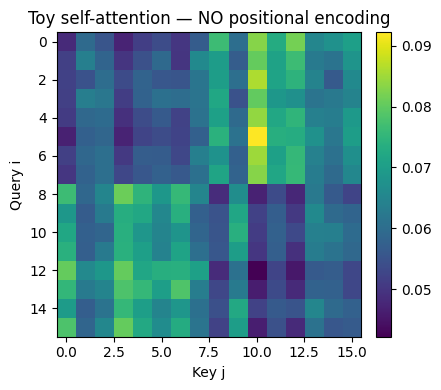

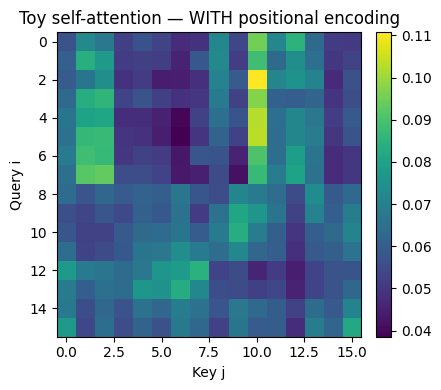

NO PE: pattern “a blocchi” per somiglianza di contenuto - i due mezzi cluster si ascoltano fra loro
WITH PE: compaiono strutture diagonali/bande (vicini si ascoltano di più) anche a pesi random.

 Shuffle

NO PE: SE shuffli l’ordine → la matrice resta visivamente simile
permutazione delle righe/colonne a parte.

WITH PE:Se shuffli l’ordine → la matrice cambia forte.
→ Messaggio: il PE inietta informazione di posizione.


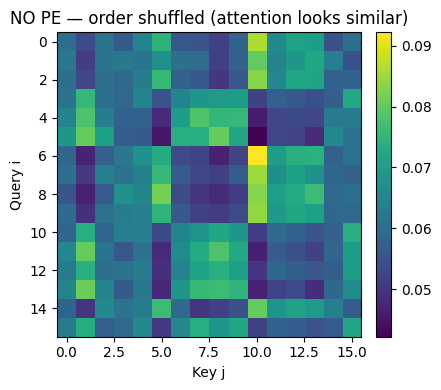

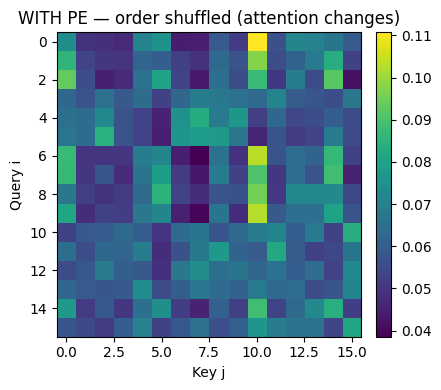

In [3]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image




def set_seed(seed=0):
  torch.manual_seed(seed)
  np.random.seed(seed)


set_seed(0)



# Utility: show heatmap

def show_heatmap(mat, title='', xlabel='', ylabel='', cmap='viridis'):
    plt.figure(figsize=(4.6, 4))
    plt.imshow(mat, cmap=cmap)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

# Utility: grid visualization for patch attention

def show_patch_attn(attn, H, W, title=''):
    # attn: (N,) attention weights for each patch
    attn_grid = attn.reshape(H, W)
    plt.figure(figsize=(4.6, 4))
    plt.imshow(attn_grid)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Sinusoidal 1D positional encoding (for toy sequence)

def sinusoid_pe_1d(N, C):
    # N positions, C dims (even)
    position = torch.arange(N).float().unsqueeze(1)  # [N, 1]
    div_term = torch.exp(torch.arange(0, C, 2).float() * (-math.log(10000.0) / C))
    pe = torch.zeros(N, C)
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe

# Sin-cos 2D positional encoding (ViT-style)

def sinusoid_pe_2d(H, W, C):
    assert C % 4 == 0, "C must be divisible by 4 for 2D sin-cos PE"
    c = C // 2
    pe_h = sinusoid_pe_1d(H, c)
    pe_w = sinusoid_pe_1d(W, c)
    # Combine by outer sum on channels: [H, c] + [W, c] -> [H, W, 2c]
    pe = torch.zeros(H, W, C)
    for h in range(H):
        for w in range(W):
            pe[h, w, :c] = pe_h[h]
            pe[h, w, c:] = pe_w[w]
    return pe.view(H*W, C)  # [N, C]

# Simple single-head self-attention module
class SelfAttention(nn.Module):
    def __init__(self, dim, d_head=64):
        super().__init__()
        self.q = nn.Linear(dim, d_head)
        self.k = nn.Linear(dim, d_head)
        self.v = nn.Linear(dim, d_head)
        self.out = nn.Linear(d_head, dim)
        self.scale = d_head ** -0.5

    def forward(self, x, return_attn=False):
        # x: [B, N, C]
        Q = self.q(x)  # [B, N, d]
        K = self.k(x)  # [B, N, d]
        V = self.v(x)  # [B, N, d]
        attn_scores = torch.matmul(Q, K.transpose(-1, -2)) * self.scale  # [B, N, N]
        attn = attn_scores.softmax(dim=-1)
        y = torch.matmul(attn, V)  # [B, N, d]
        y = self.out(y)  # [B, N, C]
        if return_attn:
            return y, attn
        return y




# ---------------------------------------------------
# PART 1 — TOY TOKENS (sequence) with/without positional encoding
# ---------------------------------------------------

# Create a 1D sequence of N tokens with two content clusters
N, C = 16, 32
x_content = torch.randn(N, C) * 0.3
# Make first half around +1, second half around -1 to create two groups
x_content[: N // 2] += 1.0
x_content[N // 2 :] -= 1.0

x_nope = x_content.clone()  # tokens WITHOUT positional encoding
x_pe = x_content + sinusoid_pe_1d(N, C)  # WITH positional encoding (absolute)

sa = SelfAttention(dim=C, d_head=32)
sa.eval()
with torch.no_grad():
    y_nope, attn_nope = sa(x_nope.unsqueeze(0), return_attn=True)  # [1,N,C], [1,N,N]
    y_pe,   attn_pe   = sa(x_pe.unsqueeze(0), return_attn=True)


print("Le matrici N×N: riga = query i, colonna = key j.")
print("Valore = quanto il token i “ascolta” j.")

# Visualize attention matrices
show_heatmap(attn_nope.squeeze(0).numpy(), title='Toy self-attention — NO positional encoding', xlabel='Key j', ylabel='Query i')
show_heatmap(attn_pe.squeeze(0).numpy(), title='Toy self-attention — WITH positional encoding', xlabel='Key j', ylabel='Query i')


print("NO PE: pattern “a blocchi” per somiglianza di contenuto - i due mezzi cluster si ascoltano fra loro")
print("WITH PE: compaiono strutture diagonali/bande (vicini si ascoltano di più) anche a pesi random.")

print("\n Shuffle\n")

print("NO PE: SE shuffli l’ordine → la matrice resta visivamente simile")
print("permutazione delle righe/colonne a parte.\n")
print("WITH PE:Se shuffli l’ordine → la matrice cambia forte.")
print("→ Messaggio: il PE inietta informazione di posizione.")


# Shuffle experiment: permute token order and recompute
perm = torch.randperm(N)
x_nope_perm = x_nope[perm]
x_pe_perm   = x_pe[perm]
with torch.no_grad():
    _, attn_nope_perm = sa(x_nope_perm.unsqueeze(0), return_attn=True)
    _, attn_pe_perm   = sa(x_pe_perm.unsqueeze(0), return_attn=True)

show_heatmap(attn_nope_perm.squeeze(0).numpy(), title='NO PE — order shuffled (attention looks similar)', xlabel='Key j', ylabel='Query i')
show_heatmap(attn_pe_perm.squeeze(0).numpy(), title='WITH PE — order shuffled (attention changes)', xlabel='Key j', ylabel='Query i')




In [4]:
def show_image_with_grid(img_tensor, P, highlight_hw=None, title=''):
    H_img, W_img = img_tensor.shape[1], img_tensor.shape[2]
    fig, ax = plt.subplots(figsize=(4.6, 4))
    ax.imshow(img_tensor.permute(1,2,0).numpy())
    # draw grid lines
    for y in range(0, H_img+1, P):
        ax.axhline(y, linewidth=0.5)
    for x in range(0, W_img+1, P):
        ax.axvline(x, linewidth=0.5)
    # highlight a chosen patch cell
    if highlight_hw is not None:
        ph, pw = highlight_hw
        rect = plt.Rectangle((pw*P, ph*P), P, P, fill=False, linewidth=2)
        ax.add_patch(rect)
    ax.set_title(title)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

def build_X_cls_batch(img_batch):
    # img_batch: [B,3,H,W]
    B = img_batch.shape[0]
    patches = img_batch.unfold(2, P, P).unfold(3, P, P)      # [B,3,Hg,Wg,P,P]
    patches = patches.permute(0,2,3,1,4,5).contiguous()       # [B,Hg,Wg,3,P,P]
    patches = patches.view(B, H_grid*W_grid, 3*P*P)           # [B,N,D]
    X = torch.einsum('bnd,dc->bnc', patches, W_embed_tr)      # [B,N,C]
    cls = torch.zeros(B, 1, C_embed, device=X.device)
    X_cls = torch.cat([cls, X], dim=1)                        # [B,N+1,C]
    return X_cls


def neighbor_mask(H, W, h, w):
        m = np.zeros((H, W), dtype=np.float32)
        for dh in [-1,0,1]:
            for dw in [-1,0,1]:
                if dh==0 and dw==0: continue
                nh, nw = h+dh, w+dw
                if 0 <= nh < H and 0 <= nw < W:
                    m[nh, nw] = 1.0
        return m

def _neighbor_and_far_masks(H, W, h, w, radius=1):
        M_near = np.zeros((H, W), dtype=np.float32)
        for dh in range(-radius, radius+1):
            for dw in range(-radius, radius+1):
                nh, nw = h+dh, w+dw
                if 0 <= nh < H and 0 <= nw < W and not (dh==0 and dw==0):
                    M_near[nh, nw] = 1.0
        M_far = np.ones((H, W), dtype=np.float32) - M_near
        M_far[h, w] = 0.0
        return M_near, M_far

def _means(vec):
            grid = vec.reshape(H_grid, W_grid)
            near = (grid*M_near).sum()/max(M_near.sum(),1)
            far  = (grid*M_far ).sum()/max(M_far.sum(),1)
            return float(near), float(far)


# Simple model wrapping our SelfAttention + CLS head
class TinyViTHead(nn.Module):
    def __init__(self, embed_dim, num_classes=10, use_pe=True, H_grid=None, W_grid=None, global_token="cls"):
        super().__init__()
        self.use_pe = use_pe
        self.global_token = global_token  # "cls" or "pooled"
        self.attn = SelfAttention(dim=embed_dim, d_head=min(32, embed_dim))
        self.cls_head = nn.Linear(embed_dim, num_classes)
        self.H_grid = H_grid
        self.W_grid = W_grid
        if use_pe:
            self.register_buffer('pe2d_full', torch.cat([torch.zeros(1, embed_dim), sinusoid_pe_2d(H_grid, W_grid, embed_dim)], dim=0))
        else:
            self.register_buffer('pe2d_full', torch.zeros(1, embed_dim))

    def forward(self, X_cls):
        # X_cls: [B, N+1, C] (already patch-embedded + CLS at index 0)
        if self.use_pe:
            X_in = X_cls + self.pe2d_full.unsqueeze(0)  # broadcast on batch
        else:
            X_in = X_cls
        Y, A = self.attn(X_in, return_attn=True)  # [B,N+1,C], [B,N+1,N+1]
        if self.global_token == "cls":
            global_vec = Y[:, 0, :]                 # [B,C]
        else:  # pooled
            global_vec = Y[:, 1:, :].mean(dim=1)    # [B,C]  mean over patch tokens only
        logits = self.cls_head(global_vec)
        return logits, A


100%|██████████| 170M/170M [00:01<00:00, 103MB/s]


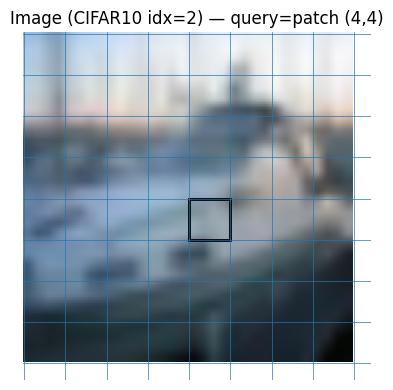

[Check 2] Shapes: N_patches=64, grid=8x8, attn=[65, 65]

[Parte 2] Patches immagine e 2D PE — Guida alla lettura:
- Visualizziamo l'immagine con griglia di patch e scegliamo la query (CLS o una patch).
- Confrontiamo le mappe di attenzione con e senza PE 2D per:
  (a) CLS→tutte le patch; (b) PatchQuery→tutte le patch.
- Aspettativa: SENZA PE l'attenzione ignora il layout; CON PE emergono pattern di vicinato.



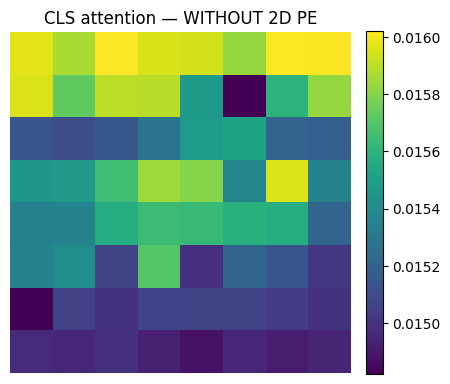


[CLS senza PE]
Il CLS distribuisce l'attenzione senza un chiaro rispetto della struttura spaziale: pesa i patch in base a affinità di contenuto casuali.
Nota: a pesi random, non aspettarti semantica — ci interessa solo l'effetto geometrico dell'assenza di posizione.



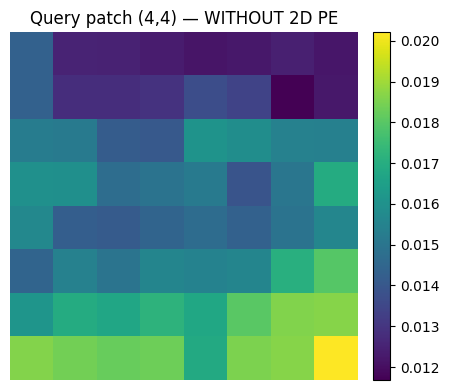


[Patch-query senza PE]
Interrogando una patch specifica, i vicini non sono privilegiati: senza posizione esplicita, 'vicino' e 'lontano' sono indistinguibili per l'attenzione.


Start mini-training supervisionato (CLS head)
Obiettivo: rendere le mappe di attenzione meno casuali e più coerenti con l'immagine.
Useremo un sottoinsieme di CIFAR10, qualche iterazione, e visualizzeremo poi le attenzioni sulla stessa immagine.



/tmp/ipython-input-3534561313.py:191: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(TRN["amp"] and device.type=='cuda'))
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/tmp/ipython-input-3534561313.py:207: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(TRN["amp"] and device.type=='cuda')):


[Train] step=200  loss=2.1357
[Train] step=400  loss=2.0774
[Train] step=600  loss=2.0881
[Train] step=800  loss=1.9512
[Train] step=1000  loss=1.9647
[Train] step=1200  loss=1.9652
[Train] step=1400  loss=1.8693
[Train] step=1600  loss=2.0591
[Train] step=1800  loss=1.9775
[Train] step=2000  loss=1.6729
[Train] step=2200  loss=2.0256
[Train] step=2400  loss=1.8311
[Train] step=2600  loss=1.9709
[Train] step=2800  loss=1.9931
[Train] step=3000  loss=1.8621
[Train] step=3200  loss=1.8832
[Train] step=3400  loss=1.8806
[Train] step=3600  loss=1.6912
[Train] step=3800  loss=2.0048
[Train] step=4000  loss=1.9151
[Train] step=4200  loss=1.7666
[Train] step=4400  loss=1.8616
[Train] step=4600  loss=2.0971
[Train] step=4800  loss=1.6199
[Train] step=5000  loss=1.9860
[Train] step=5200  loss=1.9132
[Train] step=5400  loss=1.9056
[Train] step=5600  loss=1.9076
[Train] step=5800  loss=1.7214
[Train] step=6000  loss=1.9740
[Train] step=6200  loss=1.7465
[Train] step=6400  loss=1.9045
[Train] step

In [ ]:
# ---------------------------------------------------
# PART 2 — IMAGE PATCHES (ViT-style) with 2D positional encoding
# (Revised: configurable image & query, explicit image visualization,
#  clearer Italian commentary, and sanity checks)
# ---------------------------------------------------


# ---------------------------------------------------
# PART 3 — LIGHT TRAINING to make attentions more meaningful
# ---------------------------------------------------
# We repeat the ViT-style patch exercise but add a tiny supervised head and
# train for a few iterations, so the attention becomes less random and easier to interpret.
# Code in English; prints in Italian.




# ==== CONFIG (easy to tweak) ====
CFG = {
    "dataset_index": 2,        # which CIFAR10 test image to use
    "resize_hw": (128, 128),   # working resolution (HxW)
    "patch_size": 16,          # patch size P (must divide both H and W)
    "embed_dim": 32,           # patch embedding dim
    "query_mode": "patch",    # "cls" or "patch"
    "query_patch_hw": None,    # (h, w) in patch grid; if None and query_mode=="patch" -> use center
    "global_token": "cls"     # "cls" or "pooled" (use mean-pool of patch tokens as global embedding)
}


# ==== CONFIG (training) ====
TRN = {
    "subset_size": 8024,   # number of CIFAR10 training samples to use (keep small for Colab)
    "batch_size": 64,
    "epochs": 1200,           # few passes
    "lr": 3e-3,
    "weight_decay": 1e-4,
    "use_pe": True,        # train with PE (recommended)
    "amp": True            # mixed precision if available
}

# ==== IMAGE LOADING & VISUALIZATION ====
transform = T.Compose([
    T.Resize(CFG["resize_hw"]),
    T.ToTensor(),
])

dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)
img_pil, label = dataset[CFG["dataset_index"]]
img = transform(img_pil)  # [3,H_img,W_img]

# Utility: show image with patch grid and optional highlight


# Patchify config
P = CFG["patch_size"]
H_grid = CFG["resize_hw"][0] // P
W_grid = CFG["resize_hw"][1] // P
assert CFG["resize_hw"][0] % P == 0 and CFG["resize_hw"][1] % P == 0, "resize_hw must be divisible by patch_size"

# Decide query patch (if needed)
if CFG["query_mode"].lower() == "patch":
    if CFG["query_patch_hw"] is None:
        q_h, q_w = H_grid // 2, W_grid // 2
    else:
        q_h, q_w = CFG["query_patch_hw"]
    q_h = int(max(0, min(H_grid-1, q_h)))
    q_w = int(max(0, min(W_grid-1, q_w)))
else:
    q_h = q_w = None  # not used for CLS

# Show the image and grid (highlight chosen patch if patch-query)
_show_title = (
    f"Image (CIFAR10 idx={CFG['dataset_index']}) — query={'CLS' if CFG['query_mode']=='cls' else f'patch ({q_h},{q_w})'}"
)
show_image_with_grid(img, P, None if CFG["query_mode"]=="cls" else (q_h, q_w), title=_show_title)

# ==== PATCH EMBEDDINGS ====
C_embed = CFG["embed_dim"]

# Extract patches: [N, 3*P*P]
patches = img.unfold(1, P, P).unfold(2, P, P)   # [3, H_grid, W_grid, P, P]
patches = patches.permute(1,2,0,3,4).contiguous() # [H_grid, W_grid, 3, P, P]
patches = patches.view(H_grid*W_grid, 3*P*P)      # [N, D]
N = H_grid * W_grid

# Simple linear patch embedding
W_embed = torch.randn(3*P*P, C_embed) * 0.05
X = patches @ W_embed                             # [N, C_embed]

# Add a CLS token (index 0)
cls = torch.zeros(1, C_embed)
X_cls = torch.cat([cls, X], dim=0)  # [N+1, C]

# Build 2D PE for patches (+ a zero PE for CLS)
PE2d = sinusoid_pe_2d(H_grid, W_grid, C_embed)        # [N, C]
PE2d_full = torch.cat([torch.zeros(1, C_embed), PE2d], dim=0)  # [N+1, C]

X_nope = X_cls.clone()
X_pe   = X_cls + PE2d_full

sa_img = SelfAttention(dim=C_embed, d_head=32)
sa_img.eval()
with torch.no_grad():
    attn_nope = sa_img(X_nope.unsqueeze(0), return_attn=True)[1].squeeze(0)  # [N+1,N+1]
    attn_pe   = sa_img(X_pe.unsqueeze(0),   return_attn=True)[1].squeeze(0)

# shapes
print(f"[Check 2] Shapes: N_patches={N}, grid={H_grid}x{W_grid}, attn={list(attn_nope.shape)}")

print("""
[Parte 2] Patches immagine e 2D PE — Guida alla lettura:
- Visualizziamo l'immagine con griglia di patch e scegliamo la query (CLS o una patch).
- Confrontiamo le mappe di attenzione con e senza PE 2D per:
  (a) CLS→tutte le patch; (b) PatchQuery→tutte le patch.
- Aspettativa: SENZA PE l'attenzione ignora il layout; CON PE emergono pattern di vicinato.
""")

# ==== VISUALIZE: CLS attention over patches ====
attn_cls_nope = attn_nope[0, 1:].detach().cpu().numpy()
attn_cls_pe   = attn_pe[0, 1:].detach().cpu().numpy()

if CFG["global_token"].lower() == "cls":
    show_patch_attn(attn_cls_nope, H_grid, W_grid, title='CLS attention — WITHOUT 2D PE')
    print("""
[CLS senza PE]
Il CLS distribuisce l'attenzione senza un chiaro rispetto della struttura spaziale: pesa i patch in base a affinità di contenuto casuali.
Nota: a pesi random, non aspettarti semantica — ci interessa solo l'effetto geometrico dell'assenza di posizione.
""")
else:
    print("[Nota] global_token='pooled': salto le mappe CLS perché la head userà il pooled delle patch. Le mappe Patch→All restano disponibili.")

# ==== VISUALIZE: chosen patch attention over patches ====
if CFG["query_mode"].lower() == "patch":
    q_idx = 1 + (q_h * W_grid + q_w)  # +1 to skip CLS
    attn_q_nope = attn_nope[q_idx, 1:].detach().cpu().numpy()
    attn_q_pe   = attn_pe[q_idx, 1:].detach().cpu().numpy()

    # # Re-show image with highlighted query for clarity
    # show_image_with_grid(img, P, (q_h, q_w), title=_show_title + " — highlighted query")

    show_patch_attn(attn_q_nope, H_grid, W_grid, title=f'Query patch ({q_h},{q_w}) — WITHOUT 2D PE')
    print("""
[Patch-query senza PE]
Interrogando una patch specifica, i vicini non sono privilegiati: senza posizione esplicita, 'vicino' e 'lontano' sono indistinguibili per l'attenzione.
""")
else:
    print("[Nota] query_mode='cls': salto la visualizzazione Patch→All. Imposta CFG['query_mode']='patch' per provarla.")


# ==== OPTIONAL: simple quantitative probe (neighbor emphasis) ====
# Average attention weight to immediate neighbors for the chosen patch (if patch-query)
if CFG["query_mode"].lower() == "patch":

    M = neighbor_mask(H_grid, W_grid, q_h, q_w)
    neigh_mean_nope = (attn_q_nope.reshape(H_grid,W_grid)*M).sum()/M.sum()





# -------------------------- #
# Train loop (very small)    #
# -------------------------- #



# Data transforms (train)
train_tf = T.Compose([
    T.Resize(CFG["resize_hw"]),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
])

cifar_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_tf)
# Subset for speed
indices = torch.randperm(len(cifar_train))[:TRN["subset_size"]].tolist()
subset = torch.utils.data.Subset(cifar_train, indices)
loader = torch.utils.data.DataLoader(subset, batch_size=TRN["batch_size"], shuffle=True, num_workers=2, pin_memory=True)

# Patch embedding matrix reused (fresh init for fairness)
W_embed_tr = torch.randn(3*P*P, C_embed) * 0.05

# Helper: build batch of X_cls from images




device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TinyViTHead(C_embed, num_classes=10, use_pe=TRN["use_pe"], H_grid=H_grid, W_grid=W_grid, global_token=CFG["global_token"]).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=TRN["lr"], weight_decay=TRN["weight_decay"])
scaler = torch.cuda.amp.GradScaler(enabled=(TRN["amp"] and device.type=='cuda'))
criterion = nn.CrossEntropyLoss()

print("""
Start mini-training supervisionato (CLS head)
Obiettivo: rendere le mappe di attenzione meno casuali e più coerenti con l'immagine.
Useremo un sottoinsieme di CIFAR10, qualche iterazione, e visualizzeremo poi le attenzioni sulla stessa immagine.
""")

model.train()
steps = 0
for epoch in range(TRN["epochs"]):
    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        X_cls_b = build_X_cls_batch(imgs)  # [B,N+1,C]
        with torch.cuda.amp.autocast(enabled=(TRN["amp"] and device.type=='cuda')):
            logits, _ = model(X_cls_b)
            loss = criterion(logits, labels)
        opt.zero_grad(set_to_none=True)
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        steps += 1
        if steps % 200 == 0:
            print(f"[Train] step={steps}  loss={loss.item():.4f}")


print("""
[Nota] Questo training è intenzionalmente breve: non puntiamo alla massima accuracy, ma a introdurre un segnale supervisato che renda l'attenzione più interpretabile.
""")

# Evaluate on the previously selected image from PART 2
model.eval()
with torch.no_grad():
    X_single = build_X_cls_batch(img.unsqueeze(0).to(device))  # [1,N+1,C]
    logits, A = model(X_single)                                # [1,10], [1,N+1,N+1]
    A = A.squeeze(0).cpu()                                     # [N+1,N+1]
    A_post = A  # keep a named reference for downstream metrics blocks
    probs = F.softmax(logits, dim=-1).squeeze(0).cpu().numpy()

# Show predicted class and confidence
classes = cifar_train.classes
pred_idx = int(np.argmax(probs))
print(f"""
[Esito] Predizione post-training:
- Classe predetta: {classes[pred_idx]}  (confidenza ≈ {probs[pred_idx]:.2f})
Interpretazione: anche con poche iterazioni, il CLS ha imparato un segnale utile.
""")

# Visualize CLS and (optionally) patch-query attentions after training
if CFG["global_token"].lower() == "cls":
    attn_cls_trained = A[0, 1:].numpy()
    show_patch_attn(attn_cls_trained, H_grid, W_grid, title='CLS attention — AFTER tiny training')
    print("""
[CLS dopo training]
La distribuzione dell'attenzione tende a concentrarsi maggiormente su regioni plausibili dell'immagine.
Questo non garantisce 'semantica perfetta', ma spesso rende il pattern più leggibile rispetto al caso random.
""")
else:
    print("[Nota] global_token='pooled': nessuna mappa CLS dopo training (la head non usa CLS).")

if CFG["query_mode"].lower() == "patch":
    q_idx = 1 + (q_h * W_grid + q_w)
    attn_q_trained = A[q_idx, 1:].numpy()
    show_image_with_grid(img, P, (q_h, q_w), title=_show_title + " — highlighted query (trained)")
    show_patch_attn(attn_q_trained, H_grid, W_grid, title=f'Query patch ({q_h},{q_w}) — AFTER tiny training')
    print("""
[Patch-query dopo training]
Rispetto al caso non addestrato, spesso i pesi sui vicini/regioni correlate risultano più coerenti.
Se non noti differenze nette, prova a cambiare immagine/patch (CFG) o aumentare leggermente i passi di training.
""")

print("""

Conclusioni PART 3 (ITA):
- Un minimo di supervisione spinge l'attenzione a strutturarsi e migliora la leggibilità delle mappe.
- Il beneficio è visibile pur con poche iterazioni e un modello minuscolo.
- Per ulteriori miglioramenti: più passi, PE relativo, o una testa multi-head più ampia.
""")

# ==== EXTRA: Quantify Local vs Far (con grafico) — appended helper (safe to re-run) ====
# This block computes and plots the local-vs-far metric for the Patch-query
# across the three conditions: BEFORE NO-PE, BEFORE PE, AFTER (trained, PE).
# It reuses 'attn_nope_pre', 'attn_pe_pre', 'A_post', 'q_h', 'q_w', 'H_grid', 'W_grid'.

try:
    if CFG["query_mode"].lower() == "patch":
        # Recompute patch-query rows from stored matrices
        q_idx = 1 + (q_h * W_grid + q_w)
        attn_q_nope_pre = attn_nope[q_idx, 1:].detach().cpu().numpy()
        #attn_q_pe_pre   = attn_pe[q_idx, 1:].detach().cpu().numpy()
        attn_q_after    = A_post[q_idx, 1:].detach().cpu().numpy()

        M_near, M_far = _neighbor_and_far_masks(H_grid, W_grid, q_h, q_w, radius=1)


        near_nope, far_nope = _means(attn_q_nope_pre)
        #near_pe,   far_pe   = _means(attn_q_pe_pre)
        near_after, far_after = _means(attn_q_after)

        print(f"""
[Metriche Patch-query — riepilogo]
Media pesi VICINI / LONTANI (patch {q_h},{q_w}):
- NO PE   → near={near_nope:.4f} | far={far_nope:.4f}
- AFTER   → near={near_after:.4f}| far={far_after:.4f}
Lettura attesa: near cresce e far cala passando da NO PE → PE → AFTER (variabilità possibile).
""")
        labels = ['NO PE (pre)', 'AFTER (WITH PE)']
        near_vals = [near_nope, near_after]
        far_vals  = [far_nope,  far_after]
        x = np.arange(len(labels))
        width = 0.35
        plt.figure(figsize=(6.2, 3.2))
        plt.bar(x - width/2, near_vals, width, label='Vicini')
        plt.bar(x + width/2, far_vals,  width, label='Lontani')
        plt.xticks(x, labels, rotation=15)
        plt.title(f'Local vs Far — patch ({q_h},{q_w})  |  PRIMA → DOPO')
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("[Nota] CFG['query_mode']!='patch': le metriche 'Vicini vs Lontani' sono disattivate. Imposta query_mode='patch' per abilitarle.")
except Exception as e:
    print(f"[Avviso] Metriche Patch-query non calcolate: {e}")


print("""

Done. Osservazioni chiave (ITA):
- Senza PE, l'attenzione non 'sente' la posizione: il test di permutazione lo mostra chiaramente.
- Con PE 2D, compare una nozione di vicinanza e di layout, visibile sia dal CLS sia da una patch-query.
""")



Dopo mini-training: lo stesso plot spesso diventa più coerente: oltre al vicinato, emergono regioni correlate semanticamente (es. bordo dell’oggetto), perché il modello impara a “instradare” l’attenzione dove serve per la classe.

In [ ]:
# # ---------------------------------------------------
# # PART 2 — IMAGE PATCHES (ViT-style) with 2D positional encoding
# # (Minimal: show NO-PE before, then PE after training)
# # ---------------------------------------------------
# import random, numpy as np, torch
# def set_seed(s=0):
#     random.seed(s); np.random.seed(s); torch.manual_seed(s)
#     if torch.cuda.is_available(): torch.cuda.manual_seed_all(s)
# set_seed(0)

# # ==== CONFIG (easy to tweak) ====
# CFG = {
#     "dataset_index": 2,        # which CIFAR10 test image to use
#     "resize_hw": (128, 128),   # working resolution (HxW)
#     "patch_size": 16,          # patch size P (must divide both H and W)
#     "embed_dim": 64,           # patch embedding dim (raised for stability)
#     "query_mode": "patch",     # "cls" or "patch"
#     "query_patch_hw": None,    # (h, w) in patch grid; if None and query_mode=="patch" -> use center
#     "global_token": "cls"      # "cls" or "pooled" (use mean-pool of patch tokens as global embedding)
# }

# # ==== CONFIG (training) ====
# TRN = {
#     "subset_size": 8024,   # total train samples (we'll bias towards target class)
#     "batch_size": 64,
#     "epochs": 1200,        # outer loop cap (we'll stop by MAX_STEPS)
#     "lr": 3e-3,
#     "weight_decay": 1e-4,
#     "use_pe": True,        # train with PE (recommended)
#     "amp": True            # mixed precision if available
# }
# MAX_STEPS = 400  # cap steps for a crisp demo

# # ==== IMAGE LOADING & VISUALIZATION ====
# transform = T.Compose([
#     T.Resize(CFG["resize_hw"]),
#     T.ToTensor(),
# ])

# dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)
# img_pil, label = dataset[CFG["dataset_index"]]
# img = transform(img_pil)  # [3,H_img,W_img]

# # Patchify config
# P = CFG["patch_size"]
# H_grid = CFG["resize_hw"][0] // P
# W_grid = CFG["resize_hw"][1] // P
# assert CFG["resize_hw"][0] % P == 0 and CFG["resize_hw"][1] % P == 0, "resize_hw must be divisible by patch_size"

# # Decide query patch (if needed)
# if CFG["query_mode"].lower() == "patch":
#     if CFG["query_patch_hw"] is None:
#         q_h, q_w = H_grid // 2, W_grid // 2
#     else:
#         q_h, q_w = CFG["query_patch_hw"]
#     q_h = int(max(0, min(H_grid-1, q_h)))
#     q_w = int(max(0, min(W_grid-1, q_w)))
# else:
#     q_h = q_w = None  # not used for CLS

# # Show the image and grid (highlight chosen patch if patch-query)
# _show_title = (
#     f"Image (CIFAR10 idx={CFG['dataset_index']}) — query={'CLS' if CFG['query_mode']=='cls' else f'patch ({q_h},{q_w})'}"
# )
# show_image_with_grid(img, P, None if CFG["query_mode"]=="cls" else (q_h, q_w), title=_show_title)

# # ==== PATCH EMBEDDINGS ====
# C_embed = CFG["embed_dim"]

# # Extract patches: [N, 3*P*P]
# patches = img.unfold(1, P, P).unfold(2, P, P)      # [3, H_grid, W_grid, P, P]
# patches = patches.permute(1,2,0,3,4).contiguous()  # [H_grid, W_grid, 3, P, P]
# patches = patches.view(H_grid*W_grid, 3*P*P)       # [N, D]
# N = H_grid * W_grid

# # Simple linear patch embedding
# W_embed = torch.randn(3*P*P, C_embed) * 0.05
# X = patches @ W_embed                               # [N, C_embed]

# # Add a CLS token (index 0)
# cls = torch.zeros(1, C_embed)
# X_cls = torch.cat([cls, X], dim=0)                  # [N+1, C]

# # Build 2D PE for patches (+ a zero PE for CLS)
# PE2d = sinusoid_pe_2d(H_grid, W_grid, C_embed)                  # [N, C]
# PE2d_full = torch.cat([torch.zeros(1, C_embed), PE2d], dim=0)   # [N+1, C]

# X_nope = X_cls.clone()                              # BEFORE (NO-PE)
# X_pe   = X_cls + PE2d_full                          # used only AFTER (via model)

# sa_img = SelfAttention(dim=C_embed, d_head=32).eval()
# with torch.no_grad():
#     attn_nope = sa_img(X_nope.unsqueeze(0), return_attn=True)[1].squeeze(0)  # [N+1,N+1]

# print(f"[Check] N_patches={N}, grid={H_grid}x{W_grid}, attn shape (before)={list(attn_nope.shape)}")

# # ==== VISUALIZE: BEFORE (NO PE) ====
# # CLS
# if CFG["global_token"].lower() == "cls":
#     attn_cls_nope = attn_nope[0, 1:].detach().cpu().numpy()
#     show_patch_attn(attn_cls_nope, H_grid, W_grid, title='[BEFORE] CLS attention — NO PE')
#     print("[CLS — PRIMA/NO-PE] Nessuna struttura spaziale affidabile (mappa spesso diffusa/casuale).")

# # Patch-query
# if CFG["query_mode"].lower() == "patch":
#     q_idx = 1 + (q_h * W_grid + q_w)  # +1 to skip CLS
#     attn_q_nope = attn_nope[q_idx, 1:].detach().cpu().numpy()
#     show_image_with_grid(img, P, (q_h, q_w), title=_show_title + " — highlighted query")
#     show_patch_attn(attn_q_nope, H_grid, W_grid, title=f'[BEFORE] Query patch ({q_h},{q_w}) — NO PE')
#     print("[Patch-query — PRIMA/NO-PE] Il vicinato non è privilegiato: vicino/lontano indistinguibili per l’attenzione.")

#     # minimal neighbor metric (8-neighbors)
#     M = np.zeros((H_grid, W_grid), np.float32)
#     for dh in [-1,0,1]:
#         for dw in [-1,0,1]:
#             if dh==0 and dw==0: continue
#             nh, nw = q_h+dh, q_w+dw
#             if 0<=nh<H_grid and 0<=nw<W_grid: M[nh,nw]=1.0
#     near_nope = (attn_q_nope.reshape(H_grid,W_grid)*M).sum()/M.sum()
#     print(f"[Vicini — PRIMA/NO-PE] mean={near_nope:.4f}")

# # -------------------------- #
# # PART 3 — LIGHT TRAINING    #
# # -------------------------- #

# # Data transforms (train) — minimal, no augmentation (stability)
# train_tf = T.Compose([ T.Resize(CFG["resize_hw"]), T.ToTensor() ])

# # Build a biased subset: half from target class, half from others
# all_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_tf)
# target_cls = label
# idx_target = [i for i, (_, y) in enumerate(all_train) if y == target_cls][: TRN["subset_size"]//2]
# idx_other  = [i for i, (_, y) in enumerate(all_train) if y != target_cls][: TRN["subset_size"]//2]
# indices   = idx_target + idx_other
# subset    = torch.utils.data.Subset(all_train, indices)
# loader    = torch.utils.data.DataLoader(subset, batch_size=TRN["batch_size"], shuffle=True, num_workers=2, pin_memory=True)

# # Reuse SAME patch embedding for training/eval
# W_embed_tr = W_embed.clone()

# # (Defined elsewhere) TinyViTHead expects build_X_cls_batch; we keep it minimal and reuse your helper.
# # Ensure your build_X_cls_batch uses W_embed_tr internally.

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = TinyViTHead(C_embed, num_classes=10, use_pe=TRN["use_pe"],
#                     H_grid=H_grid, W_grid=W_grid, global_token=CFG["global_token"]).to(device)
# opt = torch.optim.AdamW(model.parameters(), lr=TRN["lr"], weight_decay=TRN["weight_decay"])
# scaler = torch.cuda.amp.GradScaler(enabled=(TRN["amp"] and device.type=='cuda'))
# criterion = nn.CrossEntropyLoss()

# print("\n[Start training] Mini-training supervisionato (PE attivo). Obiettivo: rendere le mappe più coerenti.\n")

# model.train()
# steps = 0
# for epoch in range(TRN["epochs"]):
#     for imgs, labels in loader:
#         imgs = imgs.to(device); labels = labels.to(device)
#         X_cls_b = build_X_cls_batch(imgs)  # must use W_embed_tr inside
#         with torch.cuda.amp.autocast(enabled=(TRN["amp"] and device.type=='cuda')):
#             logits, _ = model(X_cls_b)
#             loss = criterion(logits, labels)
#         opt.zero_grad(set_to_none=True)
#         scaler.scale(loss).backward()
#         scaler.step(opt)
#         scaler.update()
#         steps += 1
#         if steps % 20 == 0:
#             print(f"[Train] step={steps}  loss={loss.item():.4f}")
#         if steps >= MAX_STEPS:
#             break
#     if steps >= MAX_STEPS:
#         break

# print("\n[Nota] Training breve concluso. Ora visualizziamo il DOPO (PE + training).\n")

# # Evaluate on the SAME image
# model.eval()
# with torch.no_grad():
#     X_single = build_X_cls_batch(img.unsqueeze(0).to(device))
#     logits, A = model(X_single)                      # [1,10], [1,N+1,N+1]
#     A = A.squeeze(0).cpu()                           # [N+1,N+1]
#     probs = F.softmax(logits, dim=-1).squeeze(0).cpu().numpy()

# # Pred class
# classes = all_train.classes
# pred_idx = int(np.argmax(probs))
# print(f"[Esito] Classe: {classes[pred_idx]}  (conf≈{probs[pred_idx]:.2f})")

# # ==== VISUALIZE: AFTER (PE + training) ====
# # CLS
# if CFG["global_token"].lower() == "cls":
#     attn_cls_trained = A[0, 1:].numpy()
#     show_patch_attn(attn_cls_trained, H_grid, W_grid, title='[AFTER] CLS attention — WITH PE (trained)')
#     print("[CLS — DOPO/PE] Più focalizzata su regioni plausibili; mappa più leggibile rispetto a PRIMA.")

# # Patch-query
# if CFG["query_mode"].lower() == "patch":
#     q_idx = 1 + (q_h * W_grid + q_w)
#     attn_q_trained = A[q_idx, 1:].numpy()
#     show_image_with_grid(img, P, (q_h, q_w), title=_show_title + " — query (AFTER)")
#     show_patch_attn(attn_q_trained, H_grid, W_grid, title=f'[AFTER] Query patch ({q_h},{q_w}) — WITH PE (trained)')
#     # minimal neighbor metric (AFTER)
#     near_after = (attn_q_trained.reshape(H_grid,W_grid)*M).sum()/M.sum()
#     print(f"[Vicini — DOPO/PE] mean={near_after:.4f}  |  Atteso: > PRIMA ({near_nope:.4f})")
